#Pricing tool for the time homogeneous Black Karasinsky model

## Imports

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate as integrate
import scipy.optimize as optimize
from scipy.special import factorial
import scipy.stats as stats

In [ ]:
drive.mount('/content/gdrive/')
file_path = '/content/gdrive/My Drive/IEOR4724 Project/Figures/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Function definition

###Definition of the instantaneous forward rate

In [ ]:
def r_bar(t,yield_curve):
  start_index = (yield_curve.index<=t).sum()-1
  start_time = yield_curve.index[start_index]
  if t == start_time:
    return yield_curve[start_time]
  else:
    end_time =  yield_curve.index[start_index+1]
    return ((end_time-t)*yield_curve[start_time] + (t-start_time)*yield_curve[end_time])/(end_time-start_time)

###Definition of auxilliary functions

In [ ]:
def phi_r(t,u,alpha_r):
  return np.exp((t-u)*alpha_r)

def I_r(s,t,sigma_r,alpha_r):
  return sigma_r**2/2/alpha_r*(1-phi_r(s,t,alpha_r)**2)

def E(x,t,u,sigma_r,alpha_r):
  phi_r_v = phi_r(t,u,alpha_r)
  return np.exp(phi_r_v*x - phi_r_v**2*I_r(0,t,sigma_r,alpha_r)/2)

In [ ]:
def D(t,T,yield_curve):
  fun = lambda s: - r_bar(s,yield_curve)
  return np.exp(integrate.quad(fun,t,T)[0])

def I_x(s,t,sigma_r,alpha_r):
  eps_2 = sigma_r**2/alpha_r
  return I_r(s,t,sigma_r,alpha_r)/eps_2

def I_x_1(t,sigma_r,alpha_r,yield_curve):
  fun = lambda u: np.exp(alpha_r*(u-t)) * I_x(0,u,sigma_r,alpha_r) * r_bar(u,yield_curve)
  return integrate.quad(fun,0,t)[0]

def B_star(j,t1,t2,alpha_r,yield_curve):
  fun = lambda u: np.exp(alpha_r*j*(t1-u)) * r_bar(u,yield_curve)
  return integrate.quad(fun,t1,t2)[0]/factorial(j)

###Calibration to the yield curve

In [ ]:
def r_star(t,sigma_r,alpha_r,yield_curve):
  eps_2 = sigma_r**2/alpha_r
  r_star_2 = r_bar(t,yield_curve)*I_x_1(t,sigma_r,alpha_r,yield_curve)
  return eps_2 * r_star_2

In [ ]:
def r(t,x):
  r_est = r_bar(t,yield_curve) + r_star(t,sigma_r,alpha_r,yield_curve)
  return r_est * E(x,t,t,sigma_r,alpha_r)

###Zero-Coupon Bond pricing

In [ ]:
def zcb_approximation(x_hat,t,T,sigma_r,alpha_r,yield_curve):
  eps_2 = sigma_r**2/alpha_r
  eps = np.sqrt(eps_2)
  x = x_hat/eps
  D_v = D(t,T,yield_curve)
  f_star = D_v * E(-(eps*x + eps_2*I_x_1(t,sigma_r,alpha_r,yield_curve))*B_star(1,t,T,alpha_r,yield_curve),
                   t,t,sigma_r,alpha_r)
  return f_star - eps_2 * D_v * (x**2 - I_x(0,t,sigma_r,alpha_r)) * B_star(2,t,T,alpha_r,yield_curve)

def zcb_approximation_MC(n_paths,t,T,dt,sigma_r,alpha_r,yield_curve):
  precision = int(t/dt)
  dt = t/precision
  W = sigma_r*np.random.randn(precision,n_paths)
  x = np.zeros((n_paths))
  for time_step in range(precision):
    x = x*(1-alpha_r)*dt + W[time_step]
  zcb = np.apply_along_axis(lambda x_hat:zcb_approximation(x_hat,t,T,sigma_r,alpha_r,yield_curve),0,x)
  zcb_price = zcb.mean()
  mc_error = zcb.std()/np.sqrt(n_paths)
  return zcb_price,mc_error

In [ ]:
def zcb_MC(n_paths,t,T,dt,sigma_r,alpha_r,yield_curve):
  precision = int(T/dt)
  dt = T/precision
  W = sigma_r*np.random.randn(precision,n_paths)
  ln_r = np.log(yield_curve[0])*np.ones((precision+1,n_paths))
  for time_step in range(precision):
    time = time_step*dt
    mu = alpha_r*(np.log(r_bar(time,yield_curve)+r_star(time,sigma_r,alpha_r,yield_curve)) - ln_r[time_step])
    ln_r[time_step+1] = ln_r[time_step] + mu*dt + W[time_step]
  r = np.exp(ln_r[int(t/dt)+1:])
  if False:
    plt.plot(np.linspace(t,T,len(r)),100*r[:,:10])
    plt.ylabel('r (%)')
    plt.xlabel('t (y)')
    plt.title('Paths of the short rate')
    plt.show()
  int_r = dt*r.sum(axis=0)
  zcb = np.exp(-int_r)
  zcb_price = zcb.mean()
  mc_error = zcb.std()/np.sqrt(n_paths)
  return zcb_price,mc_error

In [ ]:
def zcb_comparison(precision,n_paths,T,dt,sigma_r,alpha_r,yield_curve):
  mc = np.zeros(precision)
  approx = mc.copy()
  time_a = np.linspace(0,T,precision+1)[:-1]
  for i in range(precision):
    t = time_a[i]
    mc[i] = zcb_MC(n_paths,t,T,dt,sigma_r,alpha_r,yield_curve)[0]
    approx[i] = zcb_approximation_MC(n_paths,t,T,dt,sigma_r,alpha_r,yield_curve)[0]
  plt.plot(time_a,mc,label='Monte Carlo')
  plt.plot(time_a,approx,label='Asymptotic')
  plt.legend()
  plt.xlabel('t (y)')
  plt.ylabel('ZCB ($)')
  plt.title(f'Prices for a {T}y ZCB')
  plt.savefig(file_path+f'Prices for a {T}y ZCB.png',dpi=1000)
  plt.show()

### Caplet pricing

In [ ]:
def caplet_approximation(K,tau,T,sigma_r,alpha_r,yield_curve):
  kappa = 1 / (1 + K*tau)
  B_star_1 = B_star(1,T-tau,T,alpha_r,yield_curve)
  I_r_v = I_r(0,T-tau,sigma_r,alpha_r)
  d_1 = np.log(D(T-tau,T,yield_curve)/kappa) + B_star_1**2/2*I_r_v
  d_1 /= B_star_1*np.sqrt(I_r_v)
  d_2 = d_1 - B_star_1*np.sqrt(I_r_v)
  C_T_K = D(0,T-tau,yield_curve)*stats.norm.cdf(-d_2)
  C_T_K -= D(0,T,yield_curve)/kappa*(stats.norm.cdf(-d_1) + I_r_v*B_star(2,T-tau,T,alpha_r,yield_curve)*d_1*stats.norm.pdf(-d_1))
  return C_T_K

In [ ]:
def caplet_MC(n_paths,K,tau,T,dt,sigma_r,alpha_r,yield_curve):
  precision = int(T/dt)
  dt = T/precision
  W = sigma_r*np.random.randn(precision,n_paths)
  ln_r = np.log(yield_curve[0])*np.ones((precision+1,n_paths))
  for time_step in range(precision):
    time = time_step*dt
    mu = alpha_r*(np.log(r_bar(time,yield_curve)+r_star(time,sigma_r,alpha_r,yield_curve)) - ln_r[time_step])
    ln_r[time_step+1] = ln_r[time_step] + mu*dt + W[time_step]
  T_tau_step = int((T-tau)/dt)+1
  r_T_tau = np.exp(ln_r[T_tau_step:])
  int_r_T_tau = dt*r_T_tau.sum(axis=0)
  zcb_T_tau = np.exp(-int_r_T_tau)
  kappa = 1 / (1 + K*tau)
  payoff = 1/zcb_T_tau - 1/kappa
  payoff[payoff<=0] = 0
  r = np.exp(ln_r[1:])
  int_r = dt*r.sum(axis=0)
  zcb = np.exp(-int_r)
  d_payoff = zcb*payoff
  caplet_price = d_payoff.mean()
  mc_error = d_payoff.std()/np.sqrt(n_paths)
  return caplet_price,mc_error

In [ ]:
def caplet_comparison(n_paths,K_values,tau,T,dt,sigma_r,alpha_r,yield_curve):
  mc = np.zeros_like(K_values)
  approx = mc.copy()
  for i in range(len(K_values)):
    K = K_values[i]
    mc[i] = caplet_MC(n_paths,K,tau,T,dt,sigma_r,alpha_r,yield_curve)[0]
    approx[i] = caplet_approximation(K,tau,T,sigma_r,alpha_r,yield_curve)
  plt.plot(100*K_values,mc,label='Monte Carlo')
  plt.plot(100*K_values,approx,label='Asymptotic')
  plt.legend()
  plt.xlabel('K (%)')
  plt.ylabel('Caplet ($)')
  plt.title(f'Prices for a Caplet, tau={tau} T={T}')
  plt.savefig(file_path+f'Prices for a Caplet tau={tau} T={T}.png',dpi=1000)
  plt.show()

##Running the session

###Input data - Yield curve

In [ ]:
sigma_r = 0.05
alpha_r = 2
# Yield curve data taken from US treasury of FRED API
yield_curve = pd.Series(data=[0.03,0.06,0.12,0.28,0.7,0.99,1.26,1.42,1.49,1.91,1.87],index=[0,0.25,0.5,1,2,3,5,7,10,20,30])/100

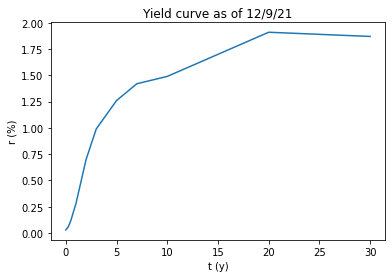

In [ ]:
plt.plot(yield_curve.index,100*yield_curve.values)
plt.xlabel('t (y)')
plt.ylabel('r (%)')
plt.title('Yield curve as of 12/9/21')
plt.savefig(file_path+'Yield_curve.png',dpi=1000)
plt.show()

### Zero-Coupon Bond

In [ ]:
n_paths = 1000
dt = 1/128
T_values = [1,2,5,10]
comparison_precision = 20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


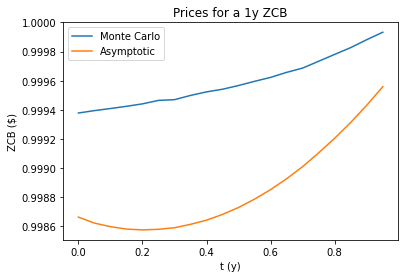

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


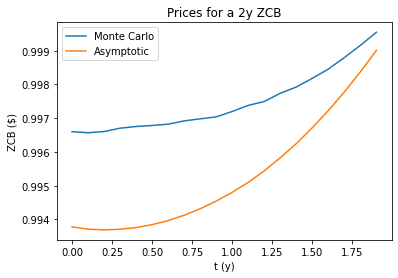

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


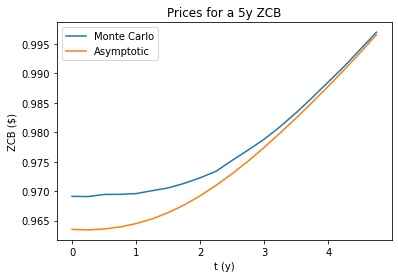

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


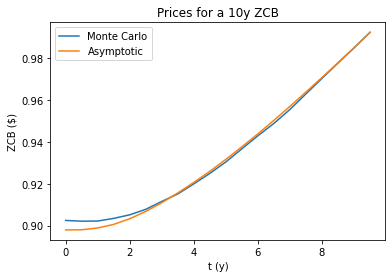

In [ ]:
for T in T_values:
  zcb_comparison(comparison_precision,n_paths,T,dt,sigma_r,alpha_r,yield_curve)

In [ ]:
%%timeit
zcb_approximation_MC(n_paths,1,5,dt,sigma_r,alpha_r,yield_curve)

10 loops, best of 5: 48.9 ms per loop


In [ ]:
%%timeit
zcb_MC(n_paths,1,5,dt,sigma_r,alpha_r,yield_curve)

1 loop, best of 5: 25.6 s per loop


### Caplet

In [ ]:
n_paths = 1000
dt = 1/128
tau = 0.25
T = 5
t = 0
K_values = np.linspace(0.9,1.8,50)/100

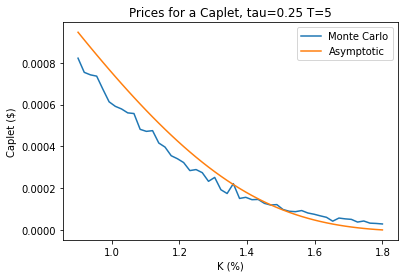

In [ ]:
caplet_comparison(n_paths,K_values,tau,T,dt,sigma_r,alpha_r,yield_curve)

In [ ]:
%%timeit
caplet_approximation(1.2/100,tau,T,sigma_r,alpha_r,yield_curve)

1 loop, best of 5: 195 ms per loop


In [ ]:
%%timeit
caplet_MC(n_paths,1.2/100,tau,T,dt,sigma_r,alpha_r,yield_curve)

1 loop, best of 5: 24.8 s per loop
